# LSTM Model

##Install the necessary libraries

In [1]:
!pip install tensorflow keras-tuner pandas scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


## Importing all the libraries

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import keras

## Loading Data

In [3]:
# Load data
full_texts = pd.read_csv('train.csv')

# # Combine for consistent preprocessing
# full_texts = pd.concat([train_data['full_text'], test_data['full_text']], axis=0)

# Tokenize text
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(full_texts)
train_sequences = tokenizer.texts_to_sequences(full_texts['full_text'])
# test_sequences = tokenizer.texts_to_sequences(test_data['full_text'])

# Pad sequences
max_length = 500
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
# test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

## Building Model and Loading training and testing data

In [4]:
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=5000, output_dim=64, input_length=max_length),
        LSTM(hp.Int('units', min_value=64, max_value=256, step=32), return_sequences=True),
        Dropout(0.5),
        LSTM(hp.Int('units', min_value=64, max_value=256, step=32)),
        Dense(1, activation='linear')
    ])
    model.compile(
        loss='mean_squared_error',
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        metrics=['mean_squared_error']
    )
    return model

X_train, X_val, y_train, y_val = train_test_split(train_padded, full_texts['score'], test_size=0.2, random_state=42)

## Setting up the Hyperparameter Tuner

In [5]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=5,
    executions_per_trial=1,
    directory='model_tuning',
    project_name='EssayScoring'
)

## Callbacks

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [7]:
from sklearn.metrics import accuracy_score, cohen_kappa_score

class MetricsLogger(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.epochs = []
        self.train_losses = []
        self.val_losses = []
        self.val_kappas = []

    def on_train_begin(self, logs=None):
        self.epochs = []
        self.train_losses = []
        self.val_losses = []
        self.val_kappas = []
        print("Training started...")

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.epochs.append(epoch)
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        print(f"Epoch {epoch + 1} ended. Calculating validation metrics...")

        y_val_pred = self.model.predict(self.validation_data[0])
        y_val_pred_classes = np.round(y_val_pred).astype(int)
        y_val_true_classes = self.validation_data[1].astype(int)
        val_kappa = cohen_kappa_score(y_val_true_classes, y_val_pred_classes, weights='quadratic')

        self.val_kappas.append(val_kappa)

        print(f'Epoch {epoch + 1}: val_kappa: {val_kappa:.4f}')


    def plot_metrics(self):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(self.epochs, self.train_losses, label='Train Loss')
        plt.plot(self.epochs, self.val_losses, label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(self.epochs, self.val_kappas, label='Validation Kappa')
        plt.title('Validation Kappa')
        plt.xlabel('Epoch')
        plt.ylabel('Kappa')
        plt.legend()

        plt.tight_layout()
        plt.show()

metrics_logger = MetricsLogger(validation_data=(X_val, y_val))

## Training Process

In [8]:
tuner.search(X_train, y_train, epochs=12, validation_data=(X_val, y_val), callbacks=[early_stopping, metrics_logger])

Trial 5 Complete [00h 03m 48s]
val_mean_squared_error: 0.5642154812812805

Best val_mean_squared_error So Far: 0.5642154812812805
Total elapsed time: 00h 17m 30s


## Getting the Best Model

In [9]:
best_model = tuner.get_best_models(num_models=1)[0]

## Evaluating the Best Model

In [10]:
loss, mse = best_model.evaluate(X_val, y_val)
print(f'Validation MSE: {mse}')

109/109 [==============================] - 3s 16ms/step - loss: 0.5642 - mean_squared_error: 0.5642
Validation MSE: 0.5642154812812805


In [11]:
metrics_logger_best = MetricsLogger(validation_data=(X_val, y_val))
best_model.fit(X_train, y_train, epochs=12, validation_data=(X_val, y_val), callbacks=[metrics_logger_best])

Training started...
Epoch 1/12
109/109 [==============================] - 2s 16ms/step
Epoch 1: val_kappa: 0.6020
433/433 [==============================] - 23s 45ms/step - loss: 0.5771 - mean_squared_error: 0.5771 - val_loss: 0.5831 - val_mean_squared_error: 0.5831
Epoch 2/12
109/109 [==============================] - 2s 16ms/step
Epoch 2: val_kappa: 0.6219
433/433 [==============================] - 19s 43ms/step - loss: 0.5789 - mean_squared_error: 0.5789 - val_loss: 0.5730 - val_mean_squared_error: 0.5730
Epoch 3/12
109/109 [==============================] - 2s 16ms/step
Epoch 3: val_kappa: 0.6180
433/433 [==============================] - 19s 43ms/step - loss: 0.5755 - mean_squared_error: 0.5755 - val_loss: 0.5671 - val_mean_squared_error: 0.5671
Epoch 4/12
109/109 [==============================] - 2s 16ms/step
Epoch 4: val_kappa: 0.6214
433/433 [==============================] - 18s 43ms/step - loss: 0.5773 - mean_squared_error: 0.5773 - val_loss: 0.5708 - val_mean_squared_error:

In [12]:
loss, mse = best_model.evaluate(X_val, y_val)
print(f'Validation MSE: {mse}')

109/109 [==============================] - 2s 16ms/step - loss: 0.5782 - mean_squared_error: 0.5782
Validation MSE: 0.578191876411438


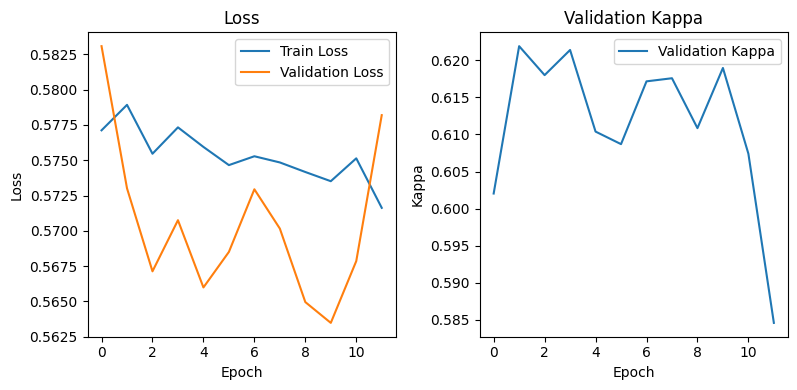

In [13]:
metrics_logger_best.plot_metrics()

In [14]:
# Print the logged metrics
train_losses = metrics_logger_best.train_losses
val_losses = metrics_logger_best.val_losses
val_kappas = metrics_logger_best.val_kappas

print("Train Losses:", train_losses)
print("Validation Losses:", val_losses)
print("Validation Kappa:", val_kappas)

Train Losses: [0.5771185755729675, 0.5789213180541992, 0.5754594802856445, 0.57732754945755, 0.5759413242340088, 0.5746537446975708, 0.5752805471420288, 0.5748423933982849, 0.5741657614707947, 0.5735141634941101, 0.5751336216926575, 0.5716270804405212]
Validation Losses: [0.5830779671669006, 0.5730095505714417, 0.5671306252479553, 0.5707519054412842, 0.5659893155097961, 0.5685059428215027, 0.5729418396949768, 0.5701572895050049, 0.5649524927139282, 0.5634788274765015, 0.5678578615188599, 0.578191876411438]
Validation Kappa: [0.6020314207271675, 0.6218912379220833, 0.6179899374891917, 0.621378036154274, 0.61037927247437, 0.6086885862316245, 0.6171498997838851, 0.6175687412399138, 0.6108432632246865, 0.6189527276392908, 0.6073942914287114, 0.5845985539847405]
